***Note: this is the Retroactivity.ipynb notebook. The
PDF version "Modules, Linearisation and Retroactivity"
is available [here](Retroactivity.pdf).***

# Introduction
As discussed by <cite data-cite="GawCra16">(Gawthrop and Crampin, 2016)</cite>:
"Computational modularity is a necessary condition for building
physically correct computational models of biomolecular systems.
However, computational modularity does not imply that module
properties (such as ultrasensitivity) are retained when a module is
incorporated into a larger system. In the context of engineering, modules often have buffer amplifiers at the interface so that they
have unidirectional connections and may thus be represented and
analysed on a block diagram or signal flow graph where the
properties of each module are retained. This will be called
behavioural modularity in this paper. However, biological networks
do not usually have this unidirectional property, but rather display
retroactivity; retroactivity modifies the properties of the
interacting modules."

The concept of retroactivity is used by, for example:
<cite data-cite="SaeKreCon04">(Julio Saez-Rodriguez, Andreas Kremling,
Holger Conzelmann, Katja Bettenbrock,
and Ernst Dieter Gilles, 2004)</cite>,
<cite data-cite="SaeKreGil05">(J. Saez-Rodriguez, A. Kremling and E.D. Gilles, 2005)</cite>,
<cite data-cite="VecMur14">(Domitilla Del Vecchio and Robert M. Murray, 2014)</cite> and
<cite data-cite="VecDyQia16">(Domitilla Del Vecchio, Aaron J. Dy and Yili Qian, 2016)</cite>.

This note looks at retroactivity in a simple linear case: a chain of reactions. The analysis is based on 
<cite data-cite="GawCra16">(Gawthrop and Crampin, 2016)</cite>.
The analysis uses [Bond Graph Tools](https://pypi.org/project/BondGraphTools/).

## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
## Some useful imports
import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import IPython.display as disp

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Modularity
import modularBondGraph as mbg

## Control systems package
import control as con

## Set quiet=False for verbose output
quiet = True

## Set slycot=True if slycot is installed (see control module)
slycot=True

## Chemical equation formatting
chemformula = True

import importlib as imp

## Allow output from within functions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# A simple reaction network: $A \Leftrightarrow B \Leftrightarrow C$
The simple reaction network $A \Leftrightarrow B \Leftrightarrow C$ can be concatenated to form a chain of $N$ such networks. There are two approaches to this:
- the modular bond graph approach using the chain() function from modularBondGraph and
- Concatenate linearised subsystem approach using the [Python Control Systems Library](https://python-control.readthedocs.io/en/0.8.3/index.html).

The species at each end of the chain are chemostats <cite data-cite="GawCra16">(Gawthrop and Crampin, 2016)</cite>.


## Bond graph model

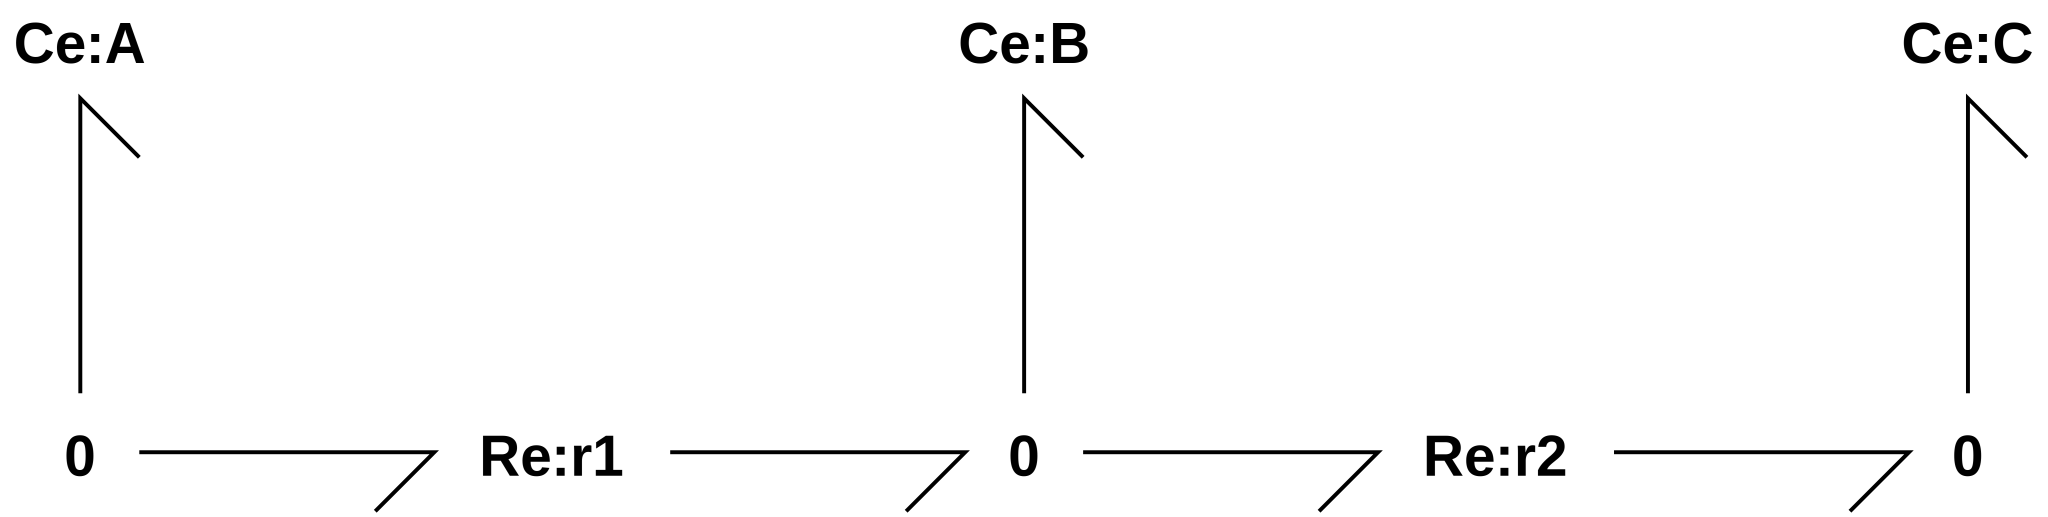


Input 1 to output 1:
-s - 1
------
s + 2

Input 1 to output 2:
  1
-----
s + 2

Input 2 to output 1:
  1
-----
s + 2

Input 2 to output 2:
-s - 1
------
s + 2

In [2]:
sbg.model('ABC_abg.svg')
import ABC_abg
disp.SVG('ABC_abg.svg')
s = st.stoich(ABC_abg.model(),quiet=True)
sc = st.statify(s,chemostats=['A','C'])

## Transfer function form (with chemostats)
sys = st.lin(s,sc,outvar = 'port',quiet=quiet)
con.ss2tf(sys)
                

## Analysis of the chain of reactions
The function analyse() performs some basic analysis on the chain:
- The poles and dc gain
-  The interaction loop-gain $L$ from equation (86) of <cite data-cite="GawCra16">(Gawthrop and Crampin, 2016)</cite>
- The step responses of the chain transfer function

Note that the chain inputs and outputs are determined by the chemostats at each end of the chain; thus the two inputs are the *potential* at each end and the two outputs are the coresponding flows.


In [3]:
def analyse(sys,Sys,csys=None):
    """Analyse the linearised systems"""
    
    print('==========================')
    print('Chain length N =',N)
    print('==========================')
    
    ## Properties of the chain
    ## Note that poles are real; np.real removes spurious imag parts.
    print('Chain poles:',np.sort(np.real(con.pole(Sys))))
    print('Chain gain:',con.dcgain(Sys))

    if csys is not None:
        print('Analyse cys')

        csys_tf = con.ss2tf(csys)
        g_ef = csys_tf[0,0]
        g_fe = csys_tf[1,1]
        L = con.negate(con.series(g_ef,g_fe))
        print("L:",L)

    ## Step responses
    k = 0
    for i in range(2):
        for j in range(2):
            k += 1
            T = np.linspace(0,20,100)
            tt,yy = con.step_response(Sys,input=j,output=i,T=T)
            plt.subplot(2,2,k)
            plt.plot(tt,yy)
            plt.title('Step response '+str(i+1)+','+str(j+1))
            plt.grid()
    plt.tight_layout()
    plt.show()


# Modular bond graph approach


## Create and analyse chain for various lengths N

In [4]:
help(mbg.chain)

Help on function chain in module modularBondGraph:

chain(model, inport='in', outport='out', N=2, quiet=False)
    Concatenate N instances of model via ports inport and outport
    The ports are represented in model as Ce components
    Ce:in in the first link of the chain and Ce:out in the last link remain as Ce components
    The method unifies Ce:out of link i and Ce:in of link i+1 by replacing them by ports 
    and connecting them to a new Ce component with associated zero junction.



Chain length N = 1
Chain poles: [-4.]
Chain gain: [[-1.  1.]
 [ 1. -1.]]


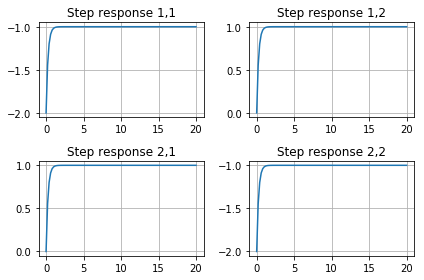

Chain transfer function:



Input 1 to output 1:
-2 s - 4
--------
  s + 4

Input 1 to output 2:
  4
-----
s + 4

Input 2 to output 1:
  4
-----
s + 4

Input 2 to output 2:
-2 s - 4
--------
  s + 4

Chain length N = 2
Chain poles: [-6.82842712 -4.         -1.17157288]
Chain gain: [[-0.5  0.5]
 [ 0.5 -0.5]]


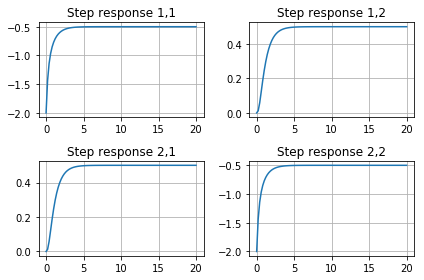

Chain transfer function:



Input 1 to output 1:
-2 s^3 - 20 s^2 - 48 s - 16
---------------------------
  s^3 + 12 s^2 + 40 s + 32

Input 1 to output 2:
           16
------------------------
s^3 + 12 s^2 + 40 s + 32

Input 2 to output 1:
           16
------------------------
s^3 + 12 s^2 + 40 s + 32

Input 2 to output 2:
-2 s^3 - 20 s^2 - 48 s - 16
---------------------------
  s^3 + 12 s^2 + 40 s + 32

Chain length N = 5
Chain poles: [-7.80422607 -7.23606798 -6.35114101 -5.23606798 -4.         -2.76393202
 -1.64885899 -0.76393202 -0.19577393]
Chain gain: [[-0.2  0.2]
 [ 0.2 -0.2]]


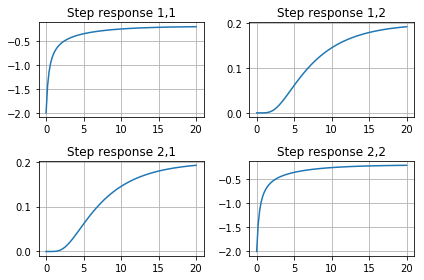

Chain transfer function:



Input 1 to output 1:
-2 s^9 - 68 s^8 - 960 s^7 - 7280 s^6 - 3.203e+04 s^5 - 8.237e+04 s^4 - 1.183e+05 s^3 - 8.448e+04 s^2 - 2.304e+04 s - 1024
-------------------------------------------------------------------------------------------------------------------------
  s^9 + 36 s^8 + 544 s^7 + 4480 s^6 + 2.184e+04 s^5 + 6.406e+04 s^4 + 1.098e+05 s^3 + 1.014e+05 s^2 + 4.224e+04 s + 5120

Input 1 to output 2:
                                                         1024
----------------------------------------------------------------------------------------------------------------------
s^9 + 36 s^8 + 544 s^7 + 4480 s^6 + 2.184e+04 s^5 + 6.406e+04 s^4 + 1.098e+05 s^3 + 1.014e+05 s^2 + 4.224e+04 s + 5120

Input 2 to output 1:
                                                         1024
----------------------------------------------------------------------------------------------------------------------
s^9 + 36 s^8 + 544 s^7 + 4480 s^6 + 2.184e+04 s^5 + 6.406e+04 s^4 + 1.098e+05 s^3 + 1.01

In [5]:

NN = [1,2,5]
for N in NN:
    
    ## Create chain
    NABC = mbg.chain(ABC_abg.model(),inport='A',outport='C',N=N,quiet=quiet)
    s = st.stoich(NABC,quiet=True)
    #print(s['reaction'])
    sc = st.statify(s,chemostats=['A','C'])
    #disp.Latex(st.sprintrl(sc,chemformula=chemformula))
    
    ## Set each Re component to have kappa = 2
    parameter = {}
    for r in s['reaction']:
        parameter['kappa_'+r] = 2
   
    ## Linearise the chain
    Sys = st.lin(s,sc,outvar = 'port',parameter=parameter,quiet=quiet)
    
    ## Analyse the properties
    analyse(sys,Sys)
    
    print('Chain transfer function:')
    con.ss2tf(Sys)

## Discussion
- The overall step response from the start to the end of the chain (step response 2,1 from $u_1$ to $y_2$) becomes higher-order and slower as $N$ increases.
- Because of retroactivity, the steady-state (DC) gain of the chain is *not* the product of the gain of each link - it is 1/N in this case.
- Because of retroactivity, the poles of the chain are (except for the pole at s=4) different for each N

# Concatenate linearised subsystem approach
As discussed by <cite data-cite="GawCra16">Gawthrop and Crampin (2016)</cite>, and as outlined in the following figure: a bond graph representing a linear system can be represented as a transfer function *when causality has been asigned*. Thus, in the example in the figure, a bond graph with two impinging bonds and causality assigned as shown, corresponds to a $2 \times 2$ transfer function matrix so that:
\begin{equation}
  \begin{pmatrix}
    y_1 \\y_2
  \end{pmatrix} =
  \begin{pmatrix}
    g_{11} & g_{12}\\
    g_{21} & g_{22}
  \end{pmatrix}
  \begin{pmatrix}
    u_1 \\u_2
  \end{pmatrix}
\end{equation}

As in the modular bond-graph approach, a Ce component is put beween each link in the chain to unify the appropriate Ce components:
- The system *sys* corresponds to the bond graph ABG_abg above with **Ce:A** and **Ce:C** replaced by ports
- The system *csys* is *sys* with a **Ce** component prepended.


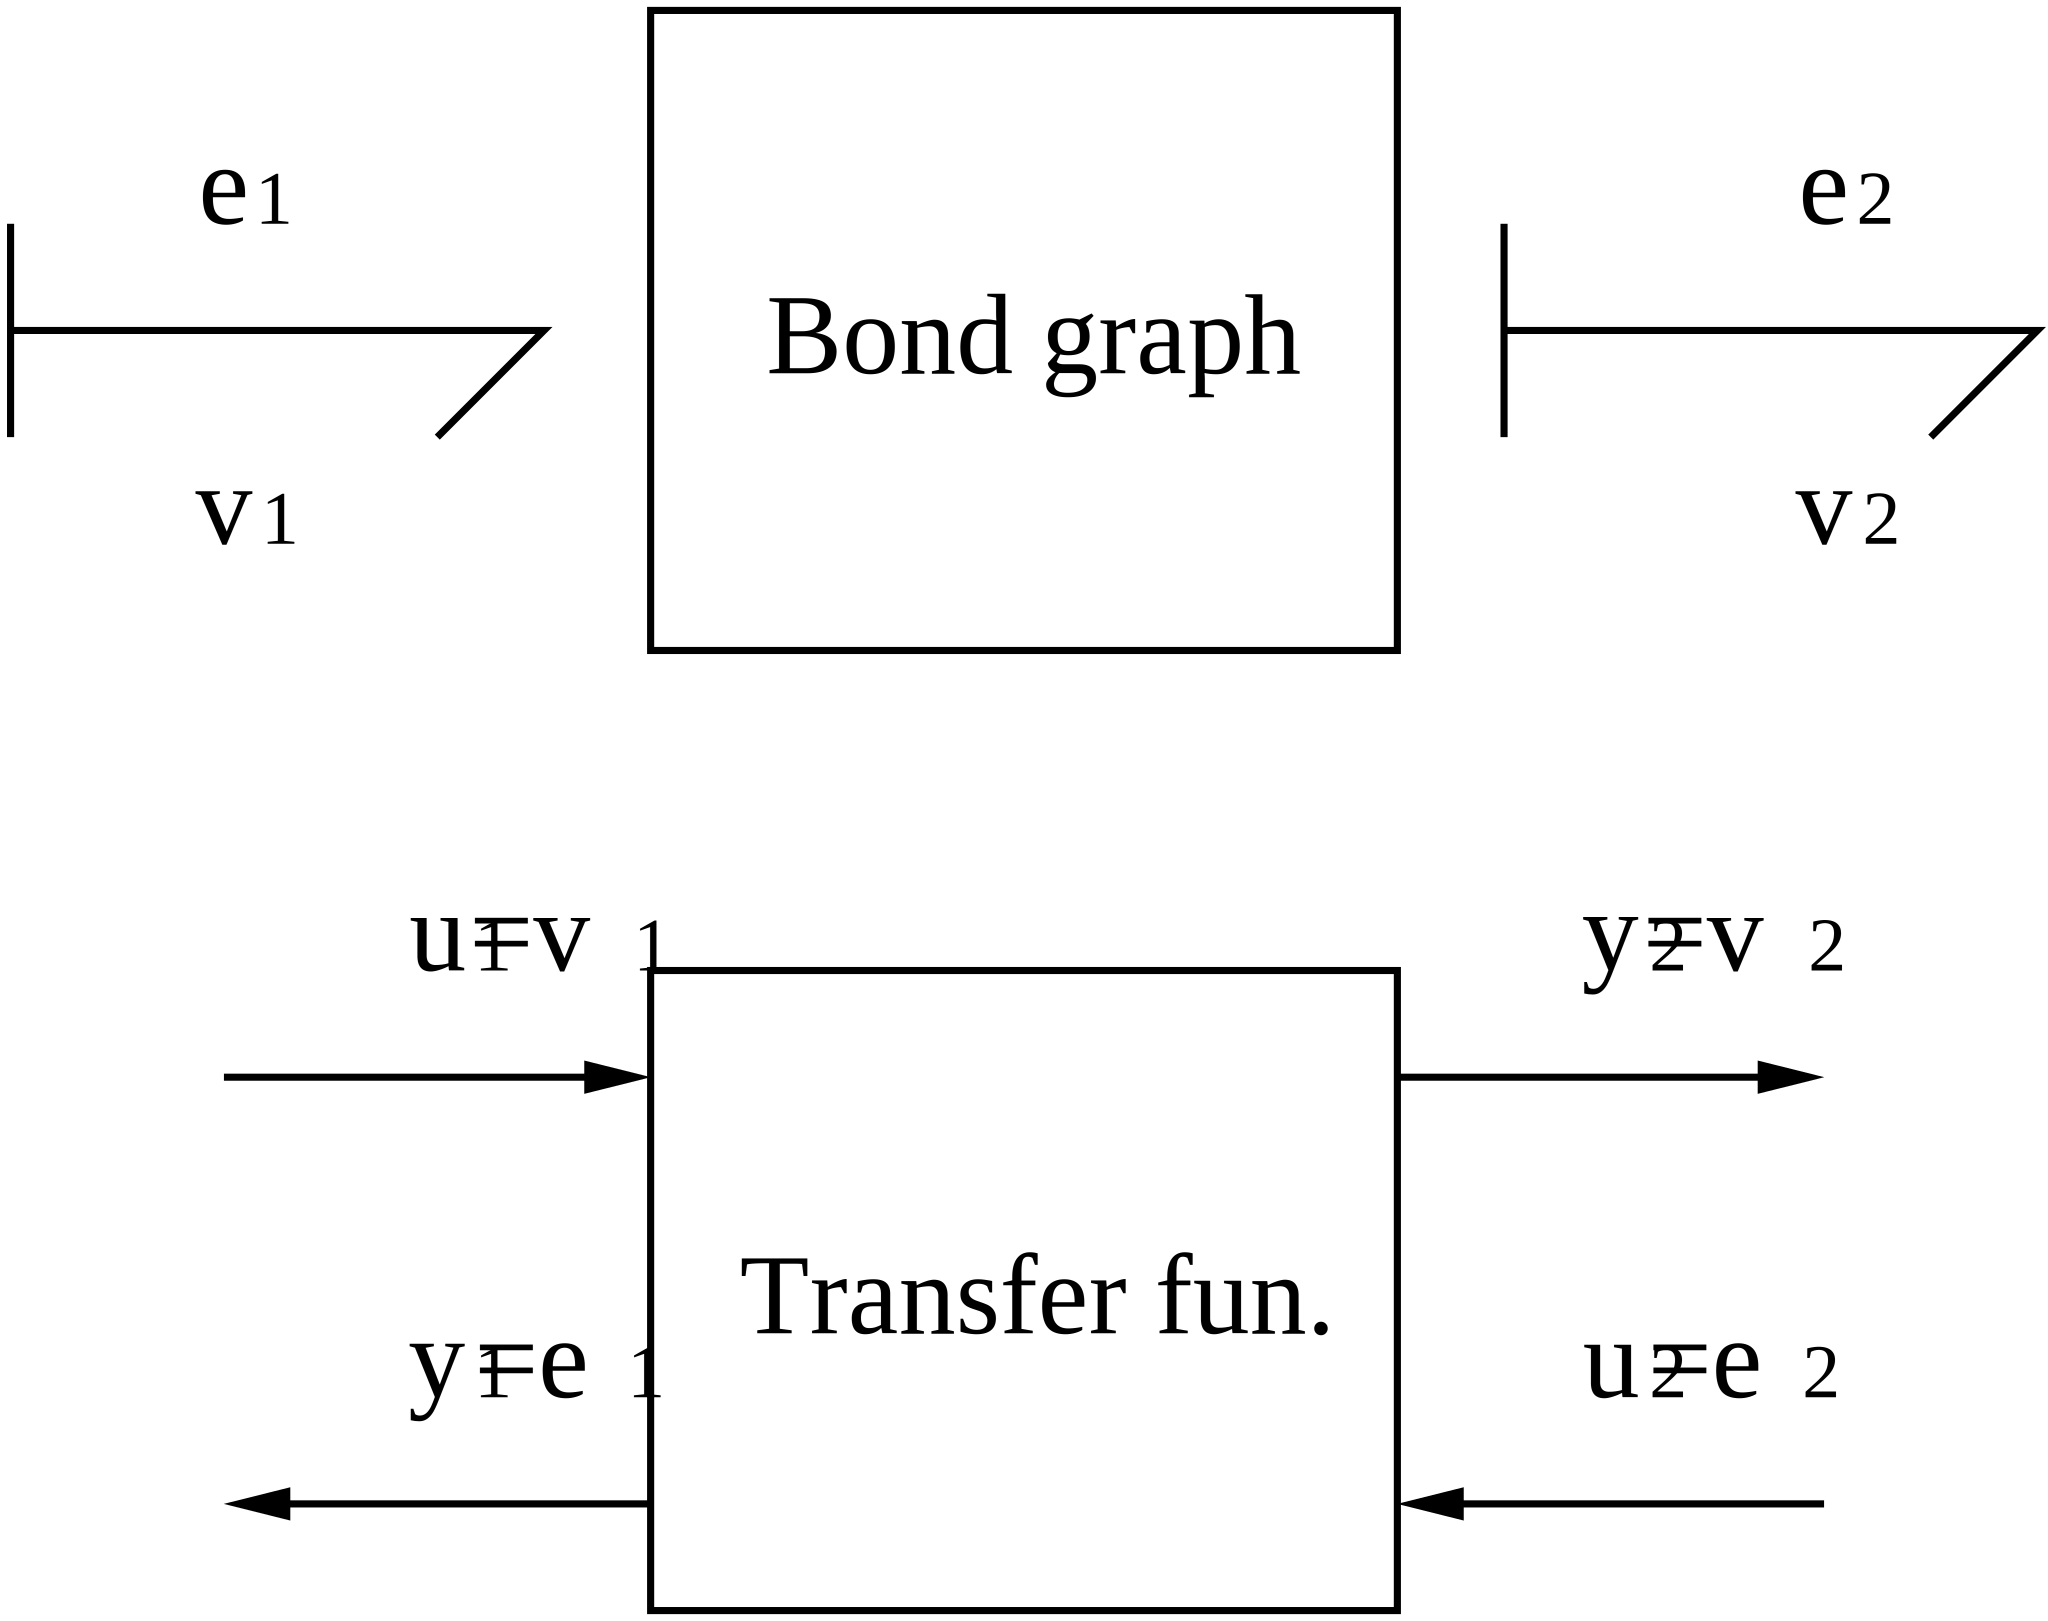

In [6]:
disp.SVG('notation.svg')

## Linearise the subsystem

In [7]:
s = st.stoich(ABC_abg.model(),quiet=quiet)
sc = st.statify(s,chemostats=['A','C'])

## Linearise
parameter = {}
for r in s['reaction']:
    parameter['kappa_'+r] = 2
sys = st.lin(s,sc,outvar = 'port',parameter=parameter,quiet=quiet)
con.ss2tf(sys)


Input 1 to output 1:
-2 s - 4
--------
  s + 4

Input 1 to output 2:
  4
-----
s + 4

Input 2 to output 1:
  4
-----
s + 4

Input 2 to output 2:
-2 s - 4
--------
  s + 4

## Create linear C component in control toolbox form

In [8]:
def makeC(Retroactive=True):
    """Create linear C component in control toolbox form
    Note that retroactivity is removed by setting output 1 to zero
    """
    Ca = 0
    Cb = np.ones((1,2))
    Cc = np.ones((2,1))
    if not Retroactive:
        Cc[0] = 0
    Cd = np.zeros((2,2))
    C = con.ss(Ca,Cb,Cc,Cd)
    return C

In [9]:
con.ss2tf(makeC(Retroactive=True))


Input 1 to output 1:
1
-
s

Input 1 to output 2:
1
-
s

Input 2 to output 1:
1
-
s

Input 2 to output 2:
1
-
s

In [10]:
con.ss2tf(makeC(Retroactive=False))


Input 1 to output 1:
0
-
1

Input 1 to output 2:
1
-
s

Input 2 to output 1:
0
-
1

Input 2 to output 2:
1
-
s

## Create chain of linearised modules


In [11]:
def makeChain(sys,C,N=2):
    """Make the chain of modules"""
    
    ## Prepend C component to sys
    CSYS = con.append(C,sys)
    Q = np.array([[2,3],[3,2]])
    inout = np.array([1,4])
    csys = con.connect(CSYS,Q,inout,inout)


    ## Recursively create chain
    Sys = sys
    for i in range(N-1):
        SYS = con.append(Sys,csys)
        Sys = con.connect(SYS,Q,inout,inout)

    return Sys,csys

Sys,csys = makeChain(sys,makeC(Retroactive=True),N=2)

con.ss2tf(csys)
con.ss2tf(Sys)
con.pole(Sys)


Input 1 to output 1:
    s + 4
-------------
s^2 + 6 s + 4

Input 1 to output 2:
      4
-------------
s^2 + 6 s + 4

Input 2 to output 1:
      4
-------------
s^2 + 6 s + 4

Input 2 to output 2:
-2 s^2 - 8 s
-------------
s^2 + 6 s + 4


Input 1 to output 1:
-2 s^3 - 20 s^2 - 48 s - 16
---------------------------
  s^3 + 12 s^2 + 40 s + 32

Input 1 to output 2:
           16
------------------------
s^3 + 12 s^2 + 40 s + 32

Input 2 to output 1:
           16
------------------------
s^3 + 12 s^2 + 40 s + 32

Input 2 to output 2:
-2 s^3 - 20 s^2 - 48 s - 16
---------------------------
  s^3 + 12 s^2 + 40 s + 32

array([-6.82842712, -4.        , -1.17157288])

## Analyse with and without retroactivity

Retroactive = True
Chain length N = 1
Chain poles: [-4.]
Chain gain: [[-1.  1.]
 [ 1. -1.]]
Analyse cys
L: 
      2 s^3 + 16 s^2 + 32 s
---------------------------------
s^4 + 12 s^3 + 44 s^2 + 48 s + 16



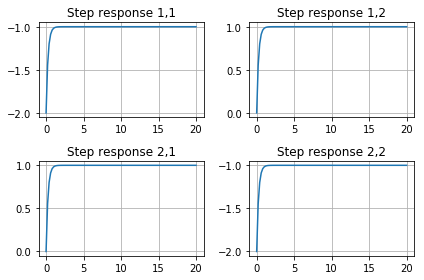

Chain transfer function:



Input 1 to output 1:
-2 s - 4
--------
  s + 4

Input 1 to output 2:
  4
-----
s + 4

Input 2 to output 1:
  4
-----
s + 4

Input 2 to output 2:
-2 s - 4
--------
  s + 4

Retroactive = True
Chain length N = 2
Chain poles: [-6.82842712 -4.         -1.17157288]
Chain gain: [[-0.5  0.5]
 [ 0.5 -0.5]]
Analyse cys
L: 
      2 s^3 + 16 s^2 + 32 s
---------------------------------
s^4 + 12 s^3 + 44 s^2 + 48 s + 16



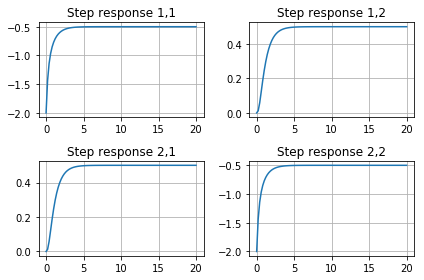

Chain transfer function:



Input 1 to output 1:
-2 s^3 - 20 s^2 - 48 s - 16
---------------------------
  s^3 + 12 s^2 + 40 s + 32

Input 1 to output 2:
           16
------------------------
s^3 + 12 s^2 + 40 s + 32

Input 2 to output 1:
           16
------------------------
s^3 + 12 s^2 + 40 s + 32

Input 2 to output 2:
-2 s^3 - 20 s^2 - 48 s - 16
---------------------------
  s^3 + 12 s^2 + 40 s + 32

Retroactive = True
Chain length N = 5
Chain poles: [-7.80422607 -7.23606798 -6.35114101 -5.23606798 -4.         -2.76393202
 -1.64885899 -0.76393202 -0.19577393]
Chain gain: [[-0.2  0.2]
 [ 0.2 -0.2]]
Analyse cys
L: 
      2 s^3 + 16 s^2 + 32 s
---------------------------------
s^4 + 12 s^3 + 44 s^2 + 48 s + 16



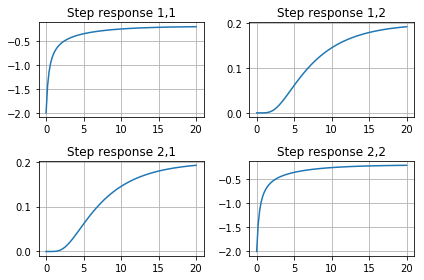

Chain transfer function:



Input 1 to output 1:
-2 s^9 - 68 s^8 - 960 s^7 - 7280 s^6 - 3.203e+04 s^5 - 8.237e+04 s^4 - 1.183e+05 s^3 - 8.448e+04 s^2 - 2.304e+04 s - 1024
-------------------------------------------------------------------------------------------------------------------------
  s^9 + 36 s^8 + 544 s^7 + 4480 s^6 + 2.184e+04 s^5 + 6.406e+04 s^4 + 1.098e+05 s^3 + 1.014e+05 s^2 + 4.224e+04 s + 5120

Input 1 to output 2:
                                                         1024
----------------------------------------------------------------------------------------------------------------------
s^9 + 36 s^8 + 544 s^7 + 4480 s^6 + 2.184e+04 s^5 + 6.406e+04 s^4 + 1.098e+05 s^3 + 1.014e+05 s^2 + 4.224e+04 s + 5120

Input 2 to output 1:
                                                         1024
----------------------------------------------------------------------------------------------------------------------
s^9 + 36 s^8 + 544 s^7 + 4480 s^6 + 2.184e+04 s^5 + 6.406e+04 s^4 + 1.098e+05 s^3 + 1.01

Retroactive = False
Chain length N = 1
Chain poles: [-4.]
Chain gain: [[-1.  1.]
 [ 1. -1.]]
Analyse cys
L: 
0
-
1



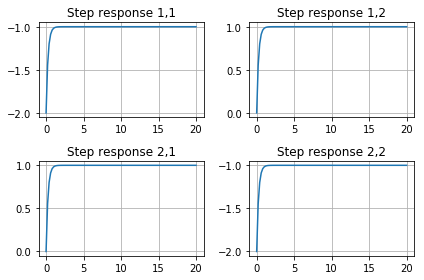

Chain transfer function:



Input 1 to output 1:
-2 s - 4
--------
  s + 4

Input 1 to output 2:
  4
-----
s + 4

Input 2 to output 1:
  4
-----
s + 4

Input 2 to output 2:
-2 s - 4
--------
  s + 4

Retroactive = False
Chain length N = 2
Chain poles: [-5.23606798 -4.         -0.76393202]
Chain gain: [[-1.  0.]
 [ 1.  0.]]
Analyse cys
L: 
0
-
1



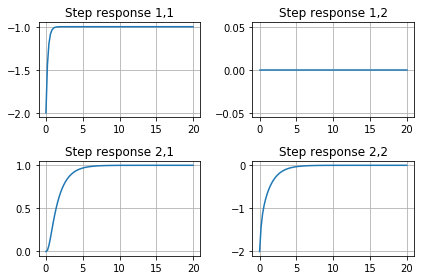

Chain transfer function:



Input 1 to output 1:
-2 s^3 - 4 s^2
--------------
  s^3 + 4 s^2

Input 1 to output 2:
           16
------------------------
s^3 + 10 s^2 + 28 s + 16

Input 2 to output 1:
0
-
1

Input 2 to output 2:
 -2 s^3 - 16 s^2 - 32 s
------------------------
s^3 + 10 s^2 + 28 s + 16

Retroactive = False
Chain length N = 5
Chain poles: [-5.23607422 -5.23607422 -5.23606798 -5.23605549 -4.         -0.76393527
 -0.76393527 -0.76393202 -0.76392553]
Chain gain: [[-1.  0.]
 [ 1.  0.]]
Analyse cys
L: 
0
-
1



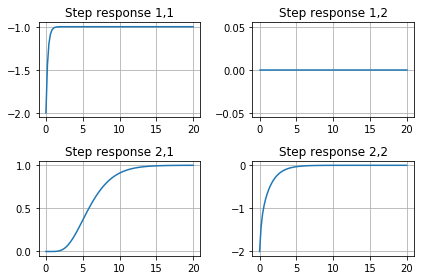

Chain transfer function:



Input 1 to output 1:
-2 s^9 - 4 s^8
--------------
  s^9 + 4 s^8

Input 1 to output 2:
                                                    1024
------------------------------------------------------------------------------------------------------------
s^9 + 28 s^8 + 328 s^7 + 2080 s^6 + 7728 s^5 + 1.709e+04 s^4 + 2.214e+04 s^3 + 1.638e+04 s^2 + 6400 s + 1024

Input 2 to output 1:
0
-
1

Input 2 to output 2:
-2 s^9 - 52 s^8 - 560 s^7 - 3216 s^6 - 1.056e+04 s^5 - 1.978e+04 s^4 - 2.01e+04 s^3 - 1.024e+04 s^2 - 2048 s
------------------------------------------------------------------------------------------------------------
s^9 + 28 s^8 + 328 s^7 + 2080 s^6 + 7728 s^5 + 1.709e+04 s^4 + 2.214e+04 s^3 + 1.638e+04 s^2 + 6400 s + 1024

In [12]:
for Retroactive in [True,False]:
    for N in NN:
        print('==========================')
        print('Retroactive =',Retroactive)
        print('==========================')
        C = makeC(Retroactive=Retroactive)
        Sys,csys =  makeChain(sys,C,N=N)
        analyse(sys,Sys,csys=csys)
        print('Chain transfer function:')
        con.ss2tf(Sys)

## Compute product of transfer functions

In [13]:
## Initial value
G21 = con.ss2tf(sys)[1,0]
for i in range(N):
    print('==========================')
    print('Chain length N =',i+1)
    print('==========================')
    print(G21)
    G21 = con.series(G21,con.ss2tf(csys)[1,0])

Chain length N = 1

  4
-----
s + 4

Chain length N = 2

           16
------------------------
s^3 + 10 s^2 + 28 s + 16

Chain length N = 3

                     64
--------------------------------------------
s^5 + 16 s^4 + 92 s^3 + 224 s^2 + 208 s + 64

Chain length N = 4

                                 256
---------------------------------------------------------------------
s^7 + 22 s^6 + 192 s^5 + 840 s^4 + 1920 s^3 + 2208 s^2 + 1216 s + 256

Chain length N = 5

                                                    1024
------------------------------------------------------------------------------------------------------------
s^9 + 28 s^8 + 328 s^7 + 2080 s^6 + 7728 s^5 + 1.709e+04 s^4 + 2.214e+04 s^3 + 1.638e+04 s^2 + 6400 s + 1024



## Discussion
- When the linear modules are concatenated using the standard **C** component, the properties of the chain are, as expected, the same as those from the modular BG approach
- When the non-standard **C** component is used to avoid retroactivity, chain shows behavioral modularity
  - the steady-state (DC) gain of the chain *is* the product of the gain of each link
  - the poles of the chain are *the same* for each N
  - this is verified by directly computing the product of transfer functions
- But the use of this non-standard **C** implies the use of an amplifier and therfore consumes power.